In [2]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

In [72]:
baseDir = "./save/server2Models/vrnn/vrnn6/"
meansVT = torch.load(baseDir+"validation_means", map_location="cpu")
stdsVT = torch.load(baseDir+"validation_stds", map_location="cpu")
targetsVT = torch.load(baseDir+"validation_targets", map_location="cpu")
inputsVT = torch.load(baseDir+"validation_datas", map_location="cpu")
meansTT = torch.load(baseDir+"train_means", map_location="cpu")
stdsTT = torch.load(baseDir+"train_stds", map_location="cpu")
targetsTT = torch.load(baseDir+"train_targets", map_location="cpu")
inputsTT = torch.load(baseDir+"train_datas", map_location="cpu")
trainDataMean = torch.load(baseDir+"train_mean", map_location="cpu")
trainDataStd = torch.load(baseDir+"train_std", map_location="cpu")
valDataMean = torch.load(baseDir+"val_mean", map_location="cpu")
valDataStd = torch.load(baseDir+"val_std", map_location="cpu")

In [73]:
meansT = np.concatenate([p for p in meansTT], axis=1)
stdsT = np.concatenate([p for p in stdsTT], axis=1)
targetsT = np.concatenate([t for t in targetsTT], axis=1)
datasT = np.concatenate([d for d in inputsTT], axis=1)

meansV = np.concatenate([p for p in meansVT], axis=1)
stdsV = np.concatenate([p for p in stdsVT], axis=1)
targetsV = np.concatenate([t for t in targetsVT], axis=1)
datasV = np.concatenate([d for d in inputsVT], axis=1)

In [74]:
valDataMean

54.796321998246725

In [75]:
valDataStd

19.662127333664966

In [76]:
trainDataMean

54.405872814187774

In [77]:
trainDataStd

19.493445996848003

In [78]:
targetsV.shape

(12, 3425, 207)

In [79]:
datasV.shape

(12, 3425, 207)

In [80]:
datasT.shape

(12, 23975, 207)

In [81]:
targetsT.shape

(12, 23975, 207)

In [134]:
def getScaledSamples(generatorMean, generatorStd, dataMean, dataStd):
    standardizedSamples = np.random.normal(generatorMean, generatorStd, size=(100, generatorMean.shape[0]))
    samples = (standardizedSamples * dataStd) + dataMean
    meanofsamples = np.mean(samples, axis=0)
    stdofsamples = np.std(samples, axis=0)
    return samples, meanofsamples, stdofsamples

In [135]:
def plotRandomInstanceVRNN(means, stds, targets, datas, dataset, dataMean, dataStd):
    instance = np.random.randint(targets.shape[1])
    sensor = np.random.randint(targets.shape[2])
    m = means[:, instance, sensor]
    std = stds[:, instance, sensor]
    t = targets[:, instance, sensor]
    d = datas[:,instance, sensor]
    predSamples, samplesMean, samplesStd = getScaledSamples(m, std, dataMean, dataStd)
    plt.plot(range(0,60, 5),samplesMean, label="pred")
    plt.fill_between(range(0,60, 5),samplesMean-1.96*samplesStd, samplesMean+1.96*samplesStd, alpha=0.5)
    plt.plot(range(0,60, 5),t, label="target")
    plt.plot(range(-60,0, 5), d, label="input")
    plt.legend()
    plt.xlabel("Minutes relative to prediction time")
    plt.ylabel("Speed (mph)")
    plt.title("random sensor sample {}".format(dataset))
    plt.show()

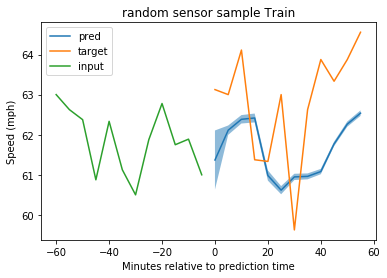

In [150]:
plotRandomInstanceVRNN(meansT,stdsT, targetsT, datasT, "Train", trainDataMean, trainDataStd)

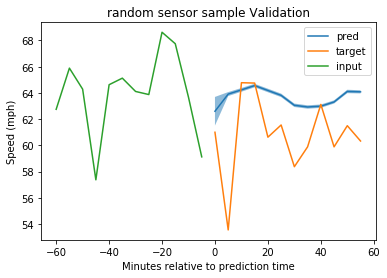

In [130]:
plotRandomInstanceVRNN(meansV, stdsV, targetsV, datasV, "Validation", valDataMean, valDataStd)